In [1]:
import numpy as np
import matplotlib.cm as cm
import pandas as pd
from possibilearn.kernel import GaussianKernel
import math
import itertools as it
import gurobipy as gpy

source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

iris_df = pd.read_csv(
    filepath_or_buffer=source,
    header=None,
    sep=',')

iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df.dropna(how="all", inplace=True) # drops the empty line at file-end

iris_values = iris_df.iloc[:,:4].values #array dei soli valori
iris_labels = iris_df.iloc[:,4].values #array delle etichette

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

iris_values_std = StandardScaler().fit_transform(iris_values)

pca_2d = PCA(n_components=2)
iris_values_2d = pca_2d.fit_transform(iris_values_std)

pca_3d = PCA(n_components=3)
iris_values_3d = pca_3d.fit_transform(iris_values_std)

pca_4d = PCA(n_components=4)
iris_values_4d = pca_4d.fit_transform(iris_values_std)

In [3]:
def print_graph(values, labels):
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    values = np.array(values)

    fig, axs = plt.subplots(1, 2,
    sharey=True, figsize=(15, 4))
    fig.subplots_adjust(wspace=0.2)

    axs[0].scatter(values[:,0],values[:,1]) #grafico di tutti i punti, senza appartenenza
    axs[0].set_xlim(-4,4)

    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), #grafico con appartenenza
                            ('blue', 'green', 'red')):
            axs[1].scatter(values[labels==lab, 0],
                        values[labels==lab, 1],
                        label=lab,
                        c=col)
    axs[1].set_xlim(-4,4)        

    plt.show()

In [4]:
def get_a_sample(x, n):
    return (np.vstack([iris_values_2d[:n], iris_values_2d[50:50+n], iris_values_2d[100:100+n]]) , 
            np.vstack([iris_labels[:n], iris_labels[50:50+n], iris_labels[100:100+n]]).ravel() )

In [5]:
def chop(x, minimum, maximum, tolerance=1e-4):
    '''Chops a number when it is sufficiently close to the extreme of
   an enclosing interval.

Arguments:

- x: number to be possibily chopped
- minimum: left extreme of the interval containing x
- maximum: right extreme of the interval containing x
- tolerance: maximum distance in order to chop x

Returns: x if it is farther than tolerance by both minimum and maximum;
         minimum if x is closer than tolerance to minimum
         maximum if x is closer than tolerance to maximum

Throws:

- ValueError if minimum > maximum or if x does not belong to [minimum, maximum]

'''
    if minimum > maximum:
        raise ValueError('Chop: interval extremes not sorted')
    if  x < minimum or x > maximum:
        raise ValueError('Chop: value not belonging to interval')

    if x - minimum < tolerance:
        x = 0
    if maximum - x < tolerance:
        x = maximum
    return x

def solve_wolf(values, k, c):
    '''
    Solves the dual optimization problem on the basis of SV clustering

    - x: array containing data to be clustered
    - k: kernel function to be used
    - c: trade-off parameter
    '''

    n=len(values)
    # p = 1.0 / (n*c)    
    
    model = gpy.Model('Wolf')
    model.setParam('OutputFlag', 0)

    for i in range(n):
        model.addVar(name="beta_%d" %i, lb=0, ub=c, vtype=gpy.GRB.CONTINUOUS)

    model.update()
    b = model.getVars()
    
    # obj == - SVC(11) 
    obj = gpy.QuadExpr()
    for i, j in it.product(range(n), range(n)):
        obj.add( b[i] * b[j], k.compute(values[i], values[j]))
    
    for i in range(n):
        obj.add( -1 * b[i] * k.compute(values[i], values[i]))
    
    model.setObjective(obj, gpy.GRB.MINIMIZE) #minimizzo -SVC(11) anzichè massimizzare SVC(11)
    
    constEqual = gpy.LinExpr()
    constEqual.add(sum(b), 1.0) # SVC(3)

    model.addConstr(constEqual, gpy.GRB.EQUAL, 1)

    model.optimize()

    b_opt = [chop(v.getAttr("x"), 0, c) for v in model.getVars()]
    
    return b_opt

In [6]:
def distance_from_center(x_new, x, b_opt, k, gram_term):
    '''
    Computes the squared distance between the image of a point and the center of the found sphere
    
    - x_new: starting point
    - x: array of points to be clustered
    - b_opt: optimal value of variables in the Wolfe dual problem
    - k: kernel function
    - gram_term: common addend based on the Gram matrix
    '''
    
    d1 = k.compute(x_new, x_new)
    d2 = np.array([k.compute(x_i, x_new) for x_i in x]).dot(b_opt)
    d = d1 - 2 * d2 + gram_term
    return d

def squared_radius_and_distance(x, b_opt, k, c):
    '''
    Computes the squared squared radius of the found sphere and a function returning
    the squared distance between the image of a generic point and the sphere center
    
    - x: array of points to be clustered
    - b_opt: optimal value of variables in the Wolfe dual problem
    - k: kernel function
    - c: trade-off parameter
    
    Returns (r, d), where
    
    - r is the squared radius
    - d is the function computing the squared distance
    '''
    
    x_sv = [b for b in b_opt if 0 < b < c]
    gram = np.array(np.array([[k.compute(x1, x2) for x1 in x] for x2 in x]))
    gram_term = np.array(b_opt).dot(gram.dot(b_opt))
    d = lambda x_new: distance_from_center(x_new, x, b_opt, k, gram_term)
    r = [d(sv) for sv in x_sv]
    if len(r) == 0:
        return None
    
    return (np.mean(r), d)

In [7]:
def check_couple(x_start, x_end, radius, d, discretization_size=20):
    x_start = np.array(x_start)
    x_end = np.array(x_end)
    discretization = np.arange(0., 1+1./discretization_size, 1./discretization_size)
    for x_between in [alpha*x_start + (1-alpha)*x_end for alpha in discretization]:
        if d(x_between) > radius:
            return 0
    return 1

In [8]:
def build_clusters(x, index_v, index_sv, radius, d):
    
    '''
    Build clusters as connected component of the graph which its nodes are the non-BSV points in the 
    dataset. There is an edge between nodes i and j if for all points in the segment connecting i and j the
    squared distance from the center of the sphere is < radius
    
    - x: array of points to be clustered
    - index_v: list/array of the indexes of the non-BSV and non-SV points
    - index_sv: list/array of the indexes of the support vectors
    - radius: radius of the sphere
    - d: function computing the squared distance between two points
    '''
    import networkx as nx
    
    G = nx.Graph()
    G.add_nodes_from(index_v)
    G.add_nodes_from(index_sv)
    
    couples = [[i,j] for i in index_v for j in index_sv]
    
    for c in couples:
        if check_couple(x[c[0]], x[c[1]], radius, d):
            G.add_edge(c[0],c[1])
            
    return [list(c) for c in list(nx.connected_components(G))]

In [9]:
def clustering(x, sigma, c, labels=[], graph=False):
    
    '''
    cluster a set of points by the support vector method
    
    - x: array of points to be clustered
    - sigma: parameter of the GaussianKernel
    - c: trade-off parameter
    - labels: array of labels ì
    - graph: if True plot graphs showing which point are classified support vectors
    
    Returns (clusters, radius), where
    
    - clusters is a list of list. each sublist represent a cluster.
    - r is the squared radius
    '''
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    if(graph):
        print_graph(x, labels)
        
    k = GaussianKernel(sigma) 
    
    betas = solve_wolf(x, k, c)
    
    index_bsv = []
    index_sv = []
    index_v = []
    for i in range(len(betas)):
        if 0 < betas[i] < c:
            if(graph):
                plt.plot(x[i][0],x[i][1],'bo')
            index_sv.append(i)
        elif betas[i] == c:
            if(graph):
                plt.plot(x[i][0],x[i][1],'ro')
            index_bsv.append(i)
        else:
            if(graph):
                plt.plot(x[i][0],x[i][1],'go')
            index_v.append(i)
        
    radius, d = squared_radius_and_distance(x, betas, k, c)
    
    if(graph):
        plt.show()
        
    return build_clusters(x, index_v, index_sv, radius, d), radius

In [10]:
def count_clusters(clusters):
    return len(filter(lambda x: len(x)>1, clusters)), len(filter(lambda x: len(x)==1, clusters))

In [11]:
def find_sigma(sample, min_sigma, max_sigma, min_clusters, max_clusters, max_width, n_misclassification, c):
    
    '''
    binary research of a sigma that divied the dataset in a defined number of cluster
    
    - sample: array of points to be clustered
    - min_sigma, max_sigma: define the range of sigma
    - min_clusters, max_clusters: define the range of the number of clusters
    - max_width: define the max width of the interval for the research of sigma
    - n_misclassification: define the max number of admitted singleton cluster
    - c: tradeoff parameter
    
    '''
    a = min_sigma
    b = max_sigma
    
    while( (b-a) >= max_width ):
        
        current_sigma = (a + b)/2
        current_clusters, r = clusterize(sample, current_sigma, c)
        n_clusters, n_singleton = count_clusters(current_clusters)
        
        print("%.20f" % current_sigma)
        print(current_clusters)
        print(n_clusters)
        print('\n')
        
        if min_clusters <= n_clusters <= max_clusters:
            if n_singleton <= n_misclassification:
                return current_sigma, current_clusters
            else:
                a = current_sigma
        else:
            if n_clusters < min_clusters:
                if n_singleton > n_misclassification:
                    a = current_sigma
                else:
                    b = current_sigma
                    
            if n_clusters > max_clusters:
                    b = current_sigma
           
    return current_sigma, current_clusters

In [12]:
#sample, labels = get_a_sample(iris_values_2d, 10)
#sigma, clusters = find_sigma(sample, 0.1, 0.3, 3, 4, 1e-8, 0, 1)

In [13]:
#sample_, labels_ = get_a_sample(iris_values_2d, 15)
#sigma_, clusters_ = find_sigma(sample_, 0.1, 0.3, 3, 4, 1e-8, 0, 1)

Con campioni di diverse dimensioni sigma cambia, forse è meglio fare una find_c? visto che c è anche funzione di N

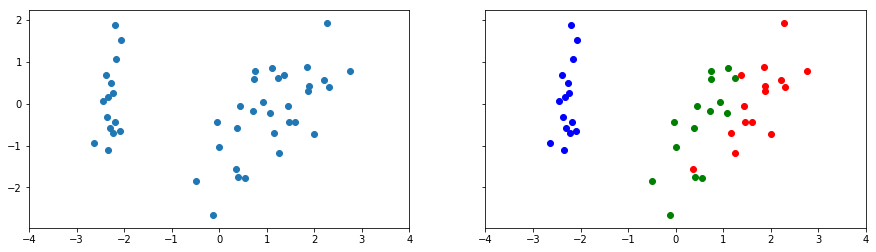

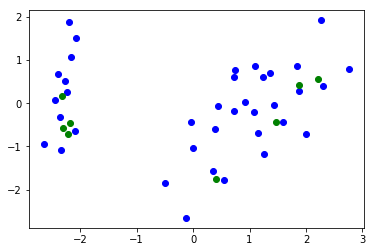

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44], [25], [39]]
1.0086584189938268


In [14]:
sample, labels = get_a_sample(iris_values_2d, 15)
sigma = 0.275
clusters, radius = clusterize(sample, sigma, 1, labels=labels, graph=True)
print clusters
print radius

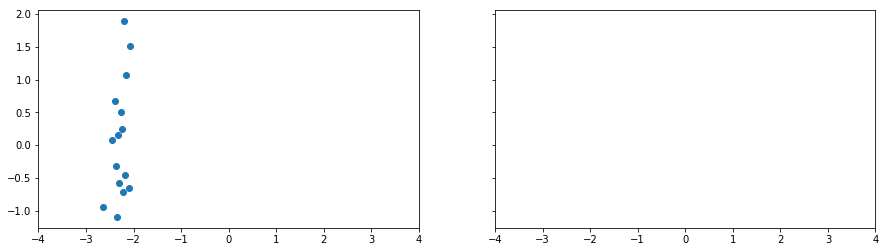

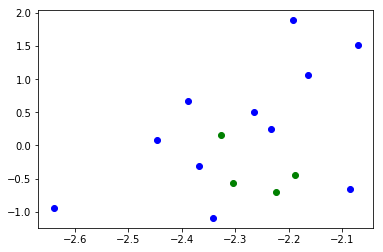

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
1.164950175848105


In [15]:
clusters0, radius0 = clustering([sample[i] for i in clusters[0]], sigma, 1, 
                                labels=[labels[i] for i in clusters[0]], graph=True)
print clusters0
print radius0

In [16]:
k = GaussianKernel(sigma)
betas = solve_wolf([sample[i] for i in clusters[0]], k, 1)
r, f = squared_radius_and_distance([sample[i] for i in clusters[0]], betas, k, 1)
print r
print [f(x) for x in [sample[i] for i in clusters[0]]]

1.164950175848105
[0.8350488185982516, 0.8350498283264824, 0.835049828289237, 0.8070918202092521, 0.8350498271680509, 0.8350498271015531, 0.8350498275431344, 0.835049827466265, 0.8350498272810977, 0.8289002627137068, 0.8350498271119478, 0.8140703236013852, 0.7972474887187755, 0.8350498272727327, 0.835049827115486]


Il raggio restituito deve essere sbagliato perchè se il raggio è una media delle distanze dal centro dei support vector
e nessun f(x) è > 1 non può esserlo la media.
Restituisco raggio al quadrato ma non distanza al quadrato?

In [17]:
def get_estimated_membership_function(cluster, sigma, c, n=1500):

    def g(m):
        return (-4 + np.random.random(2*m) * 8).reshape((m, 2))

    k = GaussianKernel(sigma)
    betas = solve_wolf(cluster, k, c)
    radius, d = squared_radius_and_distance(cluster, betas, k, 1)
    print(d(iris_values_2d[148]))
    print radius
    rndsample = g(n)
    max_distance = np.max(map(d, rndsample))
    print max_distance
    
    def estimated_membership_function(point):
        p_distance = d(point)
        if p_distance >= max_distance:
            return 0
        if p_distance <= radius:
            return 1
        
        return 1-((p_distance-radius)/(max_distance-radius))
    
    return estimated_membership_function